In [1]:
import tensorflow as tf
from tensorflow import keras 
from skimage import color
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:

dataset = np.load('/Users/mac/Dev/Project/ThermalCamera/Model/Custom/Datasets/dataset.npz')

print(list(dataset.keys()))

train_images, train_labels = dataset['train_images'], dataset['train_labels']
test_images, test_labels = dataset['test_images'], dataset['test_labels'],

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

train_images = train_images.reshape(550, 24, 32, 1)
train_labels = train_labels.reshape(550, 24, 32, 1)
test_images = test_images.reshape(61, 24, 32, 1)
test_labels = test_labels.reshape(61, 24, 32, 1)

# train_images = np.array([color.gray2rgb(img) for img in train_images])
# train_labels = np.array([color.gray2rgb(img) for img in train_labels])
# test_images = np.array([color.gray2rgb(img) for img in test_images])
# test_labels = np.array([color.gray2rgb(img) for img in test_labels])

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

['train_images', 'train_labels', 'test_images', 'test_labels']
(550, 24, 32)
(550, 24, 32)
(61, 24, 32)
(61, 24, 32)
(550, 24, 32, 1)
(550, 24, 32, 1)
(61, 24, 32, 1)
(61, 24, 32, 1)


In [3]:
print(train_images.max(), train_images.min())
print(train_labels.max(), train_labels.min())

train_images = train_images / train_images.max()
train_labels = train_labels / train_labels.max()

test_images = test_images / test_images.max()
test_labels = test_labels / test_labels.max()

print(train_images.max(), train_images.min())

255 0
255 0
1.0 0.0


(5, 48, 32, 1)


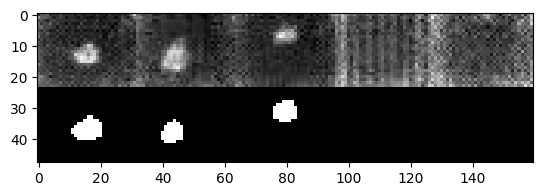

In [4]:
imgs = np.concatenate([train_images[:5], train_labels[:5]], axis = 1)
print(imgs.shape)

plt.imshow(imgs.transpose(1, 0, 2, 3).reshape(48, -1, 1), cmap = 'gray')
plt.show()

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MaxPool2D, Conv2D, Conv2DTranspose, Flatten, Reshape

# 24, 32, 1
def AutoEncoder():
    inputs = Input(shape=(24, 32, 1))
    x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(inputs)
    x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Flatten()(x)
    latent_vector = Dense(units = 10)(x)

    x = Dense(3 * 4 * 128)(latent_vector)
    x = Reshape(target_shape=(3, 4, 128))(x)
    x = Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'sigmoid')(x)
    outputs = Conv2DTranspose(filters = 1, kernel_size = 3, padding = 'same', activation = 'sigmoid')(x)

    return Model(inputs , outputs)

In [6]:
model = AutoEncoder()
model.summary()

2023-10-23 18:07:27.628522: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-23 18:07:27.628545: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-23 18:07:27.628550: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-23 18:07:27.628581: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-23 18:07:27.628600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 12, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 10)                15370     
                                                                 
 dense_1 (Dense)             (None, 1536)              16896 

In [7]:
model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
hist = model.fit(
    train_images,
    train_labels,
    validation_data = (
        test_images,
        test_labels
    ),
    epochs = 100,
    verbose = 1
)

2023-10-23 18:08:05.763865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 681ms/step


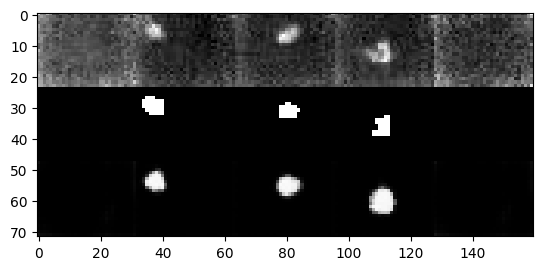

In [9]:
res = model.predict(test_labels[:5])

images = np.concatenate([test_images[:5],  test_labels[:5], res[:5]], axis = 1).transpose(1, 0, 2, 3).reshape(72, -1, 1)

plt.imshow(images, cmap='gray')
plt.show()

In [10]:
model = model.save('./filter.h5')

1/1 [==============================] - 1s 837ms/step


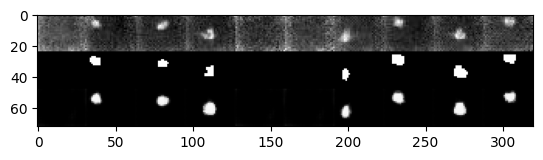

In [12]:
res = model.predict(test_labels[:10])

images = np.concatenate([test_images[:10],  test_labels[:10], res[:10]], axis = 1).transpose(1, 0, 2, 3).reshape(72, -1, 1)

plt.imshow(images, cmap='gray')
plt.show()

In [ ]:
"""
1.3fps -> 3.0fps ~ 4.3fps
"""

""" AutoEncoder(filter역할) -> 
                    SRCNN(업스케일링) ? (필요 여부 확인) -> 
                                        U-Net(인스턴스 세그멘테이션) || 다른 모델 """

In [ ]:
from keras.layers import Average

# 4배 upscale
def srcnn():
    inputs = Input(shape = (96, 128, 1))
    x = Conv2D(filters=64, kernel_size = 9, activation = 'relu', padding = 'same')(inputs)

    x1 = Conv2D(filters=32, kernel_size = 1, activation = 'relu', padding = 'same')(x)
    x2 = Conv2D(filters=32, kernel_size = 3, activation = 'relu', padding = 'same')(x)
    x3 = Conv2D(filters=32, kernel_size = 5, activation = 'relu', padding = 'same')(x)
    x = Average()([x1, x2, x3])

    outputs = Conv2D(filters = 3, kernel_size = 5, activation = 'relu', padding = 'same')(x)
    model =  Model(inputs, outputs)
    model.compile(loss = 'mae', optimizer='adam', metrics=['accuracy'])
    return model

srcnn_model = srcnn()